# Introduction

時系列データの異常検知を行います。

時系列データの異常検知の手法はこちらのスライドに記載しました。

今回はもっともシンプルなARモデルによる異常検知を行います。


# 各種ライブラリの取得



In [1]:
import numpy as np
import pylab
from pandas import tseries
from pandas import read_html
from random import gauss
from random import seed
from datetime import datetime
from statsmodels.tsa.ar_model import AR

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_html.html

In [2]:
wave_data = read_html('https://github.com/jamesrobertlloyd/gpss-research/blob/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=0, )

(499,)


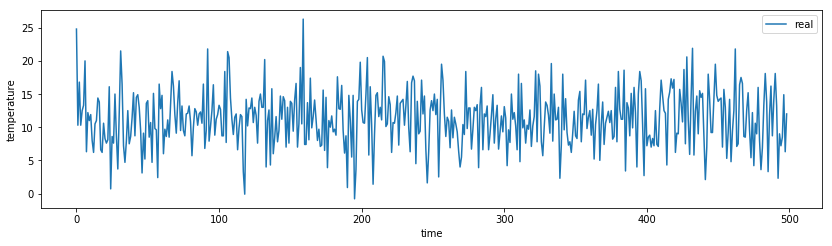

In [3]:
X_orig = wave_data[0].values[:, :, ]
X_orig = np.array([x[2] for x in X_orig])
print(X_orig.shape)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_orig, label='real')
pylab.legend(loc='upper right')
pylab.show()

# データの分割

- 学習データ
- 検証データ
- テストデータ

In [4]:
X_train = X_orig[:300]
X_valid = X_orig[300:400]
X_test = X_orig[400:]

# 学習データ

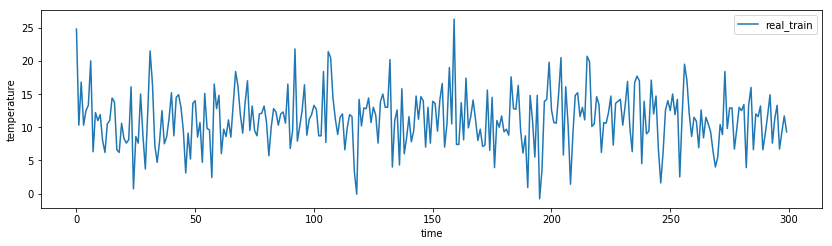

In [5]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_train, label='real_train')

pylab.legend(loc='upper right')
pylab.show()

# 検証データ

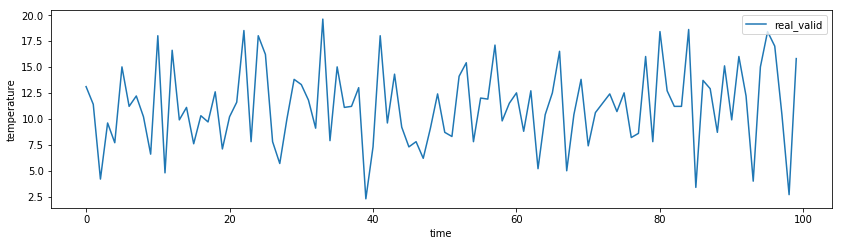

In [6]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_valid, label='real_valid')

pylab.legend(loc='upper right')
pylab.show()

# テストデータ

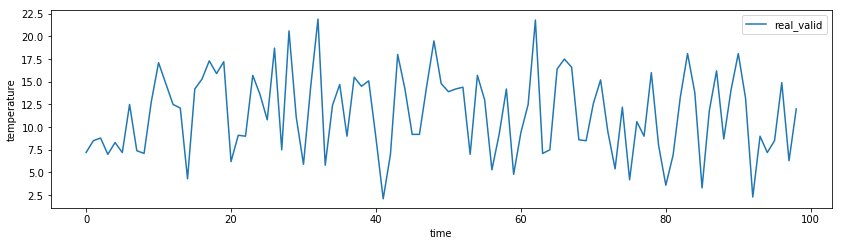

In [7]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_test, label='real_valid')

pylab.legend(loc='upper right')
pylab.show()

# Smooth process

- 移動平均によりスムージングして余分なノイズを除いています。下記の操作によってノイズを除去しています
 - windowの作成
 - 畳み込み処理

簡単な例を載せておきます。

In [8]:
# window の処理
window_len = 3
x = np.array([1, 2, 3, 4, 5])
s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
s

array([3, 2, 1, 2, 3, 4, 5, 4, 3])

In [9]:
w = np.ones(window_len, 'd')
print('window {}'.format(w))
    
y = np.convolve( w / w.sum(), s, mode='valid')
y

window [ 1.  1.  1.]


array([ 2.        ,  1.66666667,  2.        ,  3.        ,  4.        ,
        4.33333333,  4.        ])

In [10]:
def smooth(x, window_len=11):

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    
    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), s, mode='valid')
    return y

# 学習データのスムージング

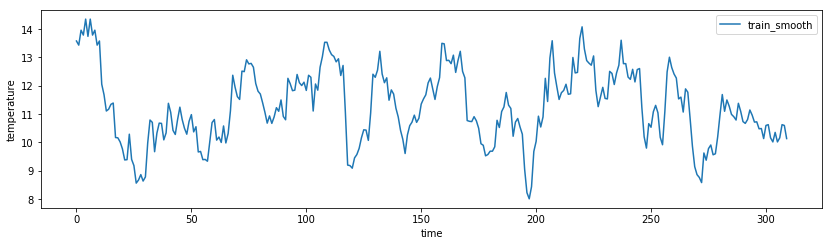

In [11]:
X_smooth_train = smooth(X_train)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_train, label='train_smooth')
pylab.legend(loc='upper right')
pylab.show()

# 検証データのスムージング

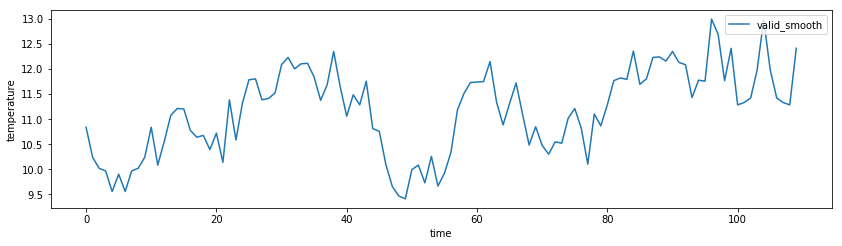

In [12]:
X_smooth_valid = smooth(X_valid)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_valid, label='valid_smooth')
pylab.legend(loc='upper right')
pylab.show()

# テストデータのスムージング

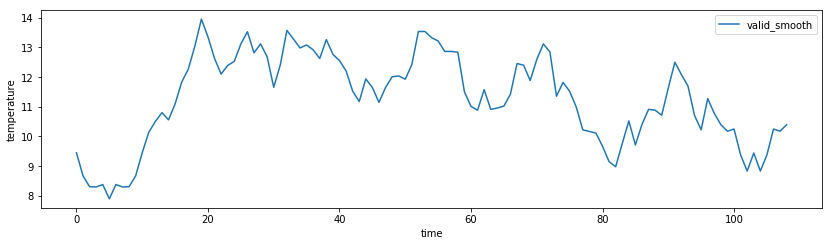

In [13]:
X_smooth_test = smooth(X_test)
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(X_smooth_test, label='valid_smooth')
pylab.legend(loc='upper right')
pylab.show()

# 異常データの作成

本来は元データに異常を付与する必要があるが分かりづらいのでスムージングしたデータに異常を付与

- スパイク型
- 波形変化
- レベルシフト

# スパイク型

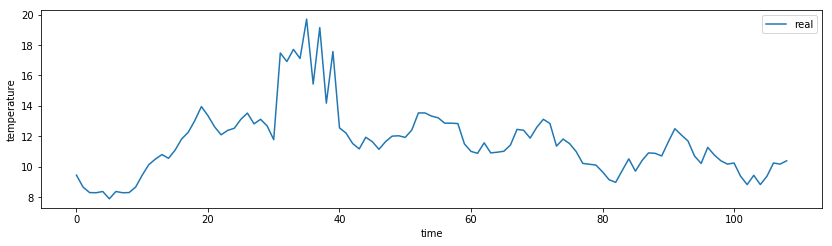

In [14]:
series = [np.abs(gauss(0.0, 5.0)) for i in range(10)]
spike_X = X_smooth_test.copy() 
spike_X[30:40] = spike_X[30:40] + series
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(spike_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# 波形変化

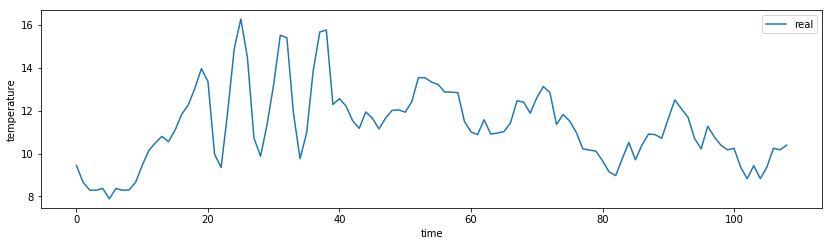

In [15]:
change_value = np.arange(0, 20, 1)
change_X = X_smooth_test.copy() 
change_X[20:40] = change_X[20:40] - (0.25 * change_X[20:40] * np.sin(change_value))
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(change_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# レベルシフト

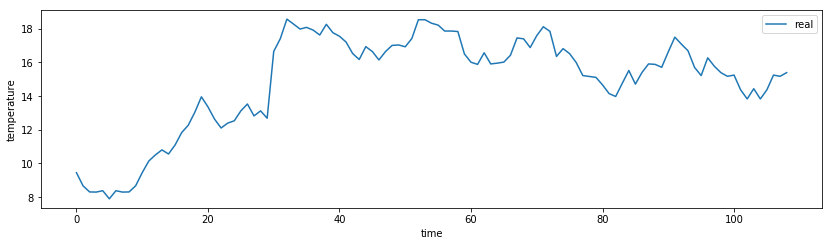

In [16]:
shift_X = X_smooth_test.copy() 
shift_X[30:] = shift_X[30:] + 5.0
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(shift_X, label='real')
pylab.legend(loc='upper right')
pylab.show()

# ARモデルの学習

- Lag: windowの幅
- Coefficients: 学習後のパラメータ

In [17]:
def train_autoregression(train_data):
    # train autoregression
    model = AR(train_data)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    print('Lag: %s' % model_fit.k_ar)
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    print('aic {}'.format(model_fit.aic))
    return model_fit

# データの予測

- history: 過去データを保存し予測に使用
- lag: 過去データの末尾のwindowサイズ分のデータを保持
- yhat: ARモデルの予測データ

In [18]:
def predict_autoregression(model, valid_data):
    window = model.k_ar
    coef = model.params
    
    history = valid_data[len(valid_data) - window:]
    history = [h for h in history]
    predictions = []

    for index, test in enumerate(valid_data):
        length = len(history)
        lag = [history[i] for i in range(length - window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d + 1] * lag[window - d - 1]
        obs = test
        predictions.append(yhat)
        history.append(obs)

    return predictions

Lag: 16
Coefficients: [ 1.29306375  1.03116025 -0.12766218  0.024919    0.03051083  0.02435715
 -0.08120145  0.03283653  0.08590711 -0.1031092  -0.08189476 -0.40351871
  0.58322877 -0.12956225 -0.04407285  0.14704034 -0.1051522 ]
aic -1.4741983570220478


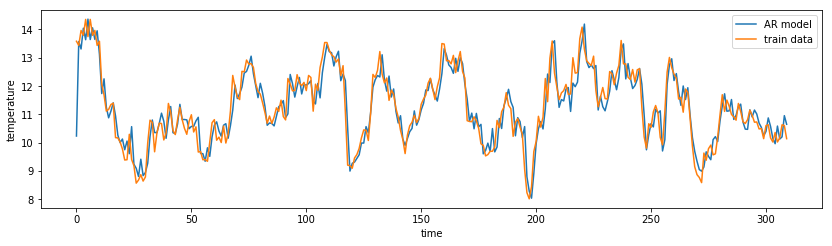

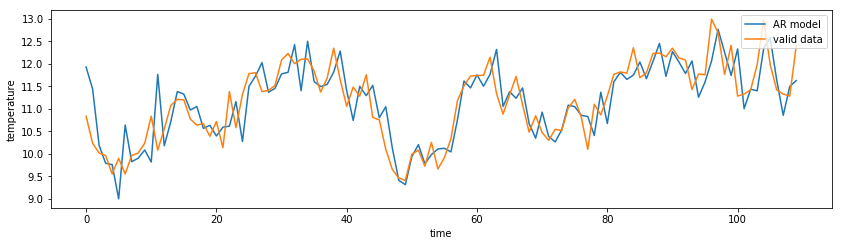

In [19]:
model = train_autoregression(X_smooth_train)

X_smooth_train = X_smooth_train
predictions = predict_autoregression(model, X_smooth_train)

X_smooth_valid = X_smooth_valid
predictions_valid = predict_autoregression(model, X_smooth_valid)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(predictions, label='AR model')
pylab.plot(X_smooth_train, label='train data')
pylab.legend(loc='upper right')
pylab.show()

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('temperature')
pylab.plot(predictions_valid, label='AR model')
pylab.plot(X_smooth_valid, label='valid data')
pylab.legend(loc='upper right')
pylab.show()

# Anomaly Score

異常度の計算部分
- 初回の計算は分散が不定なので1で固定
- 学習データで導出した分散を使用

In [20]:
def calculate_mse(value, predict_value, variance=1.0):
    mse_value = [(v - p_v)**2 / variance for v, p_v in zip(value, predict_value)]
    return mse_value


mse_value_org = calculate_mse(X_smooth_train, predictions)
mse_value_variance = np.var(mse_value_org)
mse_value = calculate_mse(X_smooth_train, predictions, mse_value_variance)

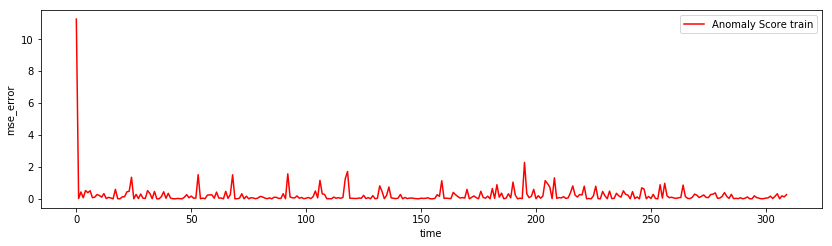

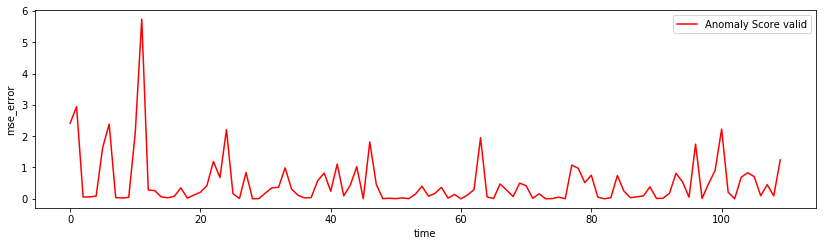

threshold value 5.737344444572401


In [21]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot(mse_value_org, "r", label='Anomaly Score train')
pylab.legend(loc='upper right')
pylab.show()

mse_value_valid = calculate_mse(X_smooth_valid, predictions_valid, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot(mse_value_valid, "r", label='Anomaly Score valid')
pylab.legend(loc='upper right')
pylab.show()

threshold = np.max(mse_value_valid)
print("threshold value {}".format(threshold))

# Anomaly Detection

# Normal Data Case

正常データは異常として検知しないかを確認

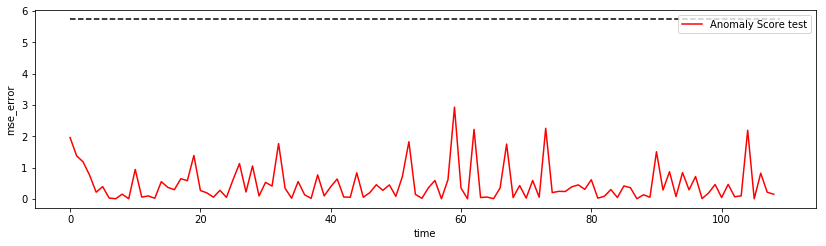

In [22]:
X_smooth_test = X_smooth_test
predictions_test = predict_autoregression(model, X_smooth_test)

mse_value_test = calculate_mse(X_smooth_test, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test, "r", label='Anomaly Score test')
pylab.legend(loc='upper right')
pylab.show()

# Spike Wave Case

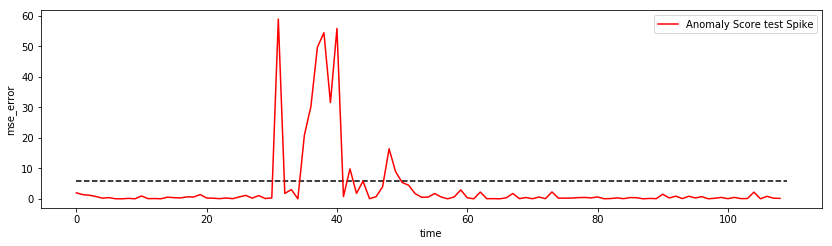

In [23]:
spike_X = spike_X
predictions_test = predict_autoregression(model, spike_X)

mse_value_test = calculate_mse(spike_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test, "r", label='Anomaly Score test Spike')
pylab.legend(loc='upper right')
pylab.show()

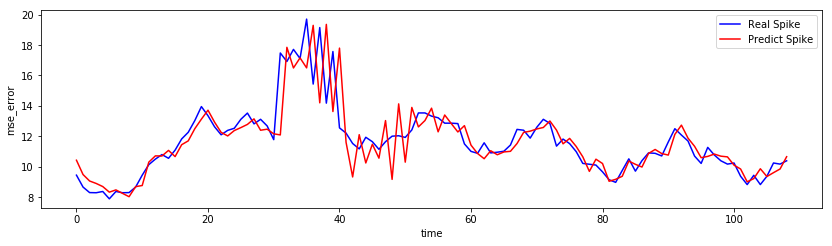

In [24]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot(spike_X, "b", label='Real Spike')
pylab.plot(predictions_test, "r", label='Predict Spike')
pylab.legend(loc='upper right')
pylab.show()

# Change Wave Case

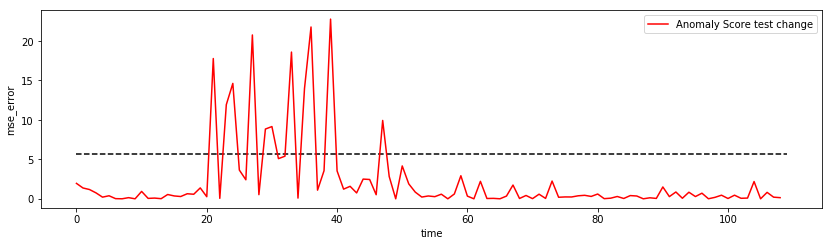

In [25]:
change_X = change_X
predictions_test = predict_autoregression(model, change_X)

mse_value_test = calculate_mse(change_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test, "r", label='Anomaly Score test change')
pylab.legend(loc='upper right')
pylab.show()

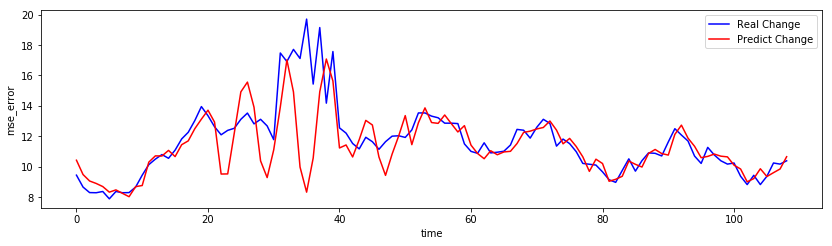

In [26]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot(spike_X, "b", label='Real Change')
pylab.plot(predictions_test, "r", label='Predict Change')
pylab.legend(loc='upper right')
pylab.show()

# Shift Wave Case

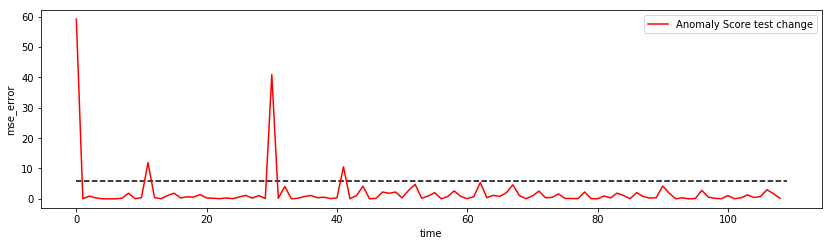

In [27]:
shift_X = shift_X
predictions_test = predict_autoregression(model, shift_X)

mse_value_test = calculate_mse(shift_X, predictions_test, mse_value_variance)

pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot((0, X_smooth_test.shape[0]), [threshold, threshold], 'k-', color = "k", ls = "dashed")
pylab.plot(mse_value_test, "r", label='Anomaly Score test change')
pylab.legend(loc='upper right')
pylab.show()

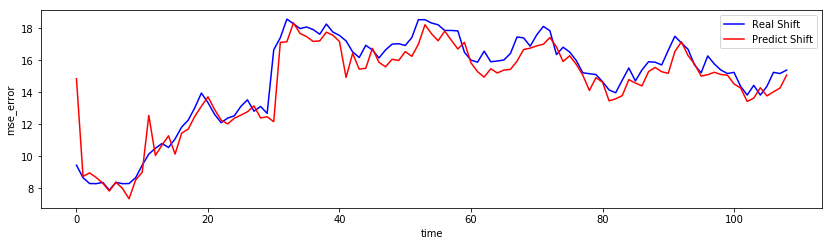

In [28]:
pylab.figure(figsize=(14, 8))
pylab.subplot(211)
pylab.xlabel('time')
pylab.ylabel('mse_error')
pylab.plot(shift_X, "b", label='Real Shift')
pylab.plot(predictions_test, "r", label='Predict Shift')
pylab.legend(loc='upper right')
pylab.show()

# 発展課題

- 異常データを作成して検知できるか試して見ましょう
 - 非周期型はまだやっていないです